    1. будем тестировать на последнем месяце с дообучением. т.е обучаем на :t-30 делаем прогноз на t-30, после на :t-29 прогноз на t-29,... и считаем так mae! -->
    2. детектируем аномалии ряда и разладку. модель будет выдавать прогноз и индикатор разладки, 
    3. таким образом mae считаем только на данных без аномалии и делаем refit с theta разладки, если изменилась ts
    4. фитим параметры sarimax на данных без аномалий и с периода разладки (default=0)
    5. с помощью tsfresh генерим фичи
    6. далее комб алгоритмом фильтруме фичи и делаем тест на стабильность (используем только sarimax) [важность фичей определяем по val1, как базы для бустинга!]
    7. при этом трейн давайте разобьем на трейн и валидацию для генерирования метафичей. т. е. на трейне подобрали гиперпараметры sarimax, garch: p, d, q, etc. 
    8. далее их зафиксировали, на валидации сделали прогноз таргета на первый день, дообучили с фикс p,d,q, ... сделали след прогноз. далее на тесте тоже самое напредиктили
    9. получили на val balance_predicted (sarimax)
    10. теперь бустингом попробуем сделать поправку к прогнозам
    11. разобьем валидацию на две части val_boost_train, val_boost_test. подберем гиперпараметры на коэффы
    12. с фикс гиперпараметрами сделаем рефит бустинга на val и уже рефитнутым бустингом с sarimax + garch прогнозим тест
    13. при этом на тесте mae не считаем по аномалиям

# Import 

In [415]:
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import scipy
import statsmodels.api as sm
from joblib import Parallel, delayed
import os
import optuna
from os.path import join
import utils
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
import requests
from itertools import product
plt.rcParams.update({'figure.figsize': (10, 5), 'figure.dpi': 100})
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import stability as st
from sklearn import linear_model
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from optuna.visualization import plot_param_importances

# Create config

In [4]:
config = {
    "data": {"path": "../data/Project 1_2024.xlsx",
            "sheet_name": "Data",
             "path_to_calendar": '../data/calendar.json',
             "key_rate_path": '../data/keyrate.csv',
             "key_rate_date_col": "date"
            },
        
    "features": {
    "target_col": "Balance",
    "date_col": "Date",
    },
    
    "analytics": {"show_analytics": False,
                  "path": "../result/analytics"},
    
    "train_params": {"train_val": 0.5, "val_boost_ratio": 0.7,  "test_size": 30}
    
    
}
with open('../config/config.json', 'w') as f:
    json.dump(config, f)

In [5]:
class TSForecastingPipeline():
    def __init__(self, config_path: str = "../config/config.json", debug: bool = True):
        self.debug = debug
        self._config_path = config_path
        self.config = self._load_config()
        print(self.config) if self.debug else None
        
        self.path_to_data = self.config["data"]["path"]
        self.sheet_name = self.config["data"]["sheet_name"]
        self.target_col = self.config["features"]["target_col"]
        self.date_col = self.config["features"]["date_col"]
        
        self.path_to_calendar = self.config["data"]["path_to_calendar"]
        self.key_rate_path = self.config["data"]["key_rate_path"]
        self.key_rate_date_col = self.config["data"]["key_rate_date_col"]
        
        
        self.data = self._load_data()
        self.data.index = pd.DatetimeIndex(self.data.index.values,
                               freq=self.data.index.inferred_freq)
        self.data.index.name = "Date"
        
        self.target = self.data[self.target_col]
        
        self.train_params = self.config["train_params"]
        self.train_val = self.config["train_params"]["train_val"]
        self.val_boost_ratio = self.config["train_params"]["val_boost_ratio"]
        self.test_size = self.config["train_params"]["test_size"]
        
        self.show_analytics = self.config["analytics"]["show_analytics"]
        self.analytics_path = self.config["analytics"]["path"]
        if self.show_analytics:
            self.ts_analysis(self.target)
        
        self.data_with_custom = self.add_custom_features(self.data, self.target_col)
        self.data_with_ts_and_custom = self.add_ts_features(self.data_with_custom, self.target_col)
        self.data_preproced = self.data_with_ts_and_custom.dropna()
        
        (self.X_trainval, self.y_trainval, 
        self.X_test, self.y_test,
        self.X_train, self.y_train, 
        self.X_val, self.y_val,
        self.X_val_boost_train,
        self.y_val_boost_train,
        self.X_val_boost_test, self.y_val_boost_test) = self.train_test_split(self.data_preproced, self.train_val, self.val_boost_ratio, self.test_size, self.target_col)
        
        
        
        self.sarimax_searcher = SarimaxSearcher()
        #fit p, d, q, P, D, Q
        best_params, best_df = self.sarimax_searcher.hyperopt_search(self.y_train)

        #sliding, one-out window prediction for feature estimation and fitting boosting
        self.pred_trainval, _ = self.sarimax_searcher.fit_predict_trainval(self.y_train, self.y_val)

        self.sarimax_result = pd.concat([self.pred_trainval, self.y_trainval], axis=1)
        self.sarimax_result.columns=["y_pred",  "y_true"]

        self.MAE_VAL = (self.sarimax_result["y_pred"] - self.sarimax_result["y_true"]).iloc[len(self.y_train):].abs().mean()

        print(f"Extending train, one out MAE for validation: {self.MAE_VAL:.02f}")
                              
    def _load_config(self):
        """
        load json config from self._config_path with paths, etc. and return it
        """
        with open(self._config_path) as f:
            config = json.load(f) 
        return config
    
    def _load_data(self):
        """
        load dataset from excel and return it
        """
        
        assert os.path.isfile(self.path_to_data), f"No such data file with path {self.path_to_data}"
        data = pd.read_excel(self.path_to_data,
                             sheet_name=self.sheet_name, 
                             parse_dates=[self.date_col], 
                             index_col=self.date_col)
        data = data[[self.target_col]]
        data = data.sort_index()
        return data
    
    def ts_analysis(self, y, save_fig=True, label="default"):
        """
        plot ts analytics for y ts vatiable with datetime index
        show it and save if save_fig to self.analytics_path/label dir
        """
        if not os.path.exists(join(self.analytics_path, label)):
            os.mkdir(join(self.analytics_path, label))       
        fig = y.plot()
        fig.set_title("target_dynamic " + f"Stationarity = {utils.stationarity_check(y)}")
        plt.savefig(join(self.analytics_path, label, "target_dynamic.png"))
        plt.show()
        fig = y.hist(bins=30)
        fig.set_title("target_distribution " + f"Normaltest = {scipy.stats.normaltest(y)}")
        plt.savefig(join(self.analytics_path, label, "target_distribution.png"))
        plt.show()
        
        fig = np.cumsum(y).plot()
        fig.set_title("CUSUM")
        plt.savefig(join(self.analytics_path, label, "cusum.png"))
        fig = utils.tsplot(y)
        fig.savefig(join(self.analytics_path, label, "tsplot.png"))
        fig = utils.plot_decomposition(y)
        fig.savefig(join(self.analytics_path, label, "additive_decomposition.png"))

        
    
    def add_ts_features(self, data, target_col):
        """
        use tsfresh to extact ts stat features with window 30 (drop first date to avoid leakage)
        """
        print("Adding TS features") if self.debug else None
        df = data.copy()[[target_col]]
        df["Dummy_id"] = 0
        df = df.reset_index()
        df_rolled = roll_time_series(df, column_id="Dummy_id", column_sort="Date",
                                     max_timeshift=30, min_timeshift=0, n_jobs=10) #closed-right interval, so we should do a shift

        df = extract_features(df_rolled.drop("Dummy_id", axis=1), 
                             column_id="id", column_sort="Date", column_value="Balance", 
                             impute_function=impute, show_warnings=False, n_jobs=10)


        df = df.set_index(df.index.map(lambda x: x[1]), drop=True)

        df.index.name = "Date"

        df = df.shift(1) #!no leak
        df = pd.concat([data.copy(), df], axis=1)
        return df
    
    def add_custom_features(self, data, target_col):
        """
        add features from feature engeneering.ipynb, so that's calendar features, lags, also rolling stats, key rate value(it was considered that we know tha value on t-1), tax days
        """
        print("Adding CUSTOM features") if self.debug else None
        df = data.copy()[[target_col]]
        df = self.add_calendar_feats(df)
        df = self.add_key_rate(df)
        df = self.add_rollings_and_lags(df, target_col)
        df = self.add_payday(df)
        df = pd.concat([data.copy().drop(columns=target_col), df], axis=1)
        return df
    
    def add_calendar_feats(self, df):
        print("Adding CALENDAR features") if self.debug else None
        df = df.copy()
        
        #calendar features
        df['weekend'] = np.where(df.index.weekday > 4, 1, 0)

        df['day_of_week'] = df.index.weekday

        day_of_week_columns = pd.get_dummies(df['day_of_week'], dtype=int)
        day_of_week_columns.columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Firday", "Saturday", "Sunday"]

        df = df.merge(day_of_week_columns, left_index=True, right_index=True)


        df['day_of_week_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 7))
        df['day_of_week_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 7))


        with open(self.path_to_calendar) as f:
            calendar = json.load(f) 

        calendar = {k: pd.to_datetime(v) for k, v in calendar.items()}

        df["holiday"] = df.index.isin(calendar["holidays"].union(calendar["nowork"])).astype(int)

        df["preholiday"] = df.index.isin(calendar["preholidays"]).astype(int)


        month = pd.get_dummies(df.index.month,prefix='month', dtype=int).set_index(df.index)

        quarter = pd.get_dummies(df.index.quarter,prefix='quarter', dtype=int).set_index(df.index)

        df = pd.concat([df, month, quarter],axis=1)
        
        df.drop(columns=["day_of_week"], inplace=True)

        return df
    
    def add_key_rate(self, df: pd.DataFrame):
        print("Adding KEY_RATE features") if self.debug else None
        df = df.copy()
        keyrate = pd.read_csv(self.key_rate_path, 
                              index_col=self.key_rate_date_col, 
                              parse_dates=[self.key_rate_date_col])

        keyrate.columns = ["keyrate"] #MAST HAVE SHIFT

        df = df.join(keyrate, on=df.index)

        df["keyrate"] = df["keyrate"].ffill() #cant'bfill
        
        return df
    
    def add_rollings_and_lags(self, data, target_col):
        """
        input: pd.DataFrame with only target and date index
        """
        print("Adding roll&lags features") if self.debug else None
        df = data.copy()[[target_col]]
        
        rolling_weekly = df[target_col].rolling(7).agg(['mean','std','median','max','min']).shift()
        rolling_weekly.columns = ["Balance_" + col + "_weekly" for col in rolling_weekly.columns]

        rolling_monthly = df[target_col].rolling(30).agg(['mean','std','median','max','min']).shift()
        rolling_monthly.columns = ["Balance_" + col + "_monthly" for col in rolling_monthly.columns]
        # we lose first 30 rows as we do this
        df = pd.concat([data.copy(), rolling_weekly, rolling_monthly], axis=1)

        df["first_lag"] = df.Balance.shift(1)
        df["second_lag"] = df.Balance.shift(2)
        return df
    
    def add_payday(self, df):
        df = df.copy()
        # Initialize target feature column
        df['payday'] = 0

        # Iterate over each row in the DataFrame
        for index, data in df.iterrows():
            if index.day in [15, 25, 28]:
                # Check if weekend, holiday, and target feature are all zero
                if data['weekend'] == 0 and data['holiday'] == 0:
                    data['payday'] = 1
                else:
                    loc = df.index.get_loc(index)
                    # If any of weekend, holiday, or target feature is 1, find the upper row where all are zero
                    lower_row_index = loc - 1
                    loc = df.index[lower_row_index]
                    while lower_row_index > -1 and (df.loc[loc, 'weekend'] == 1 or df.loc[loc, 'holiday'] == 1):
                        lower_row_index -= 1
                        loc = df.index[lower_row_index]
                    df.at[loc, "payday"] = 1

        return df
    
    
    def train_test_split(self, data, train_val_ratio, val_boost_ratio, test_size, target_col):
        """
        return X_trainval, y_trainval, X_test, y_test, X_train, y_train, X_val, y_val, X_val_boost_train, y_val_boost_train, X_val_boost_test, y_val_boost_test
        """
        df = data.copy()

        test = df.iloc[-test_size:]
        trainval = df.iloc[:-test_size]

        trainval_size = trainval.shape[0]
        train_size = int(trainval_size * train_val_ratio) #for hyperparams sarimax
        val_size = trainval_size - train_size

        val_boost_train_size = int(val_size * val_boost_ratio) #for meta features with lightgbm
        val_boost_test_size = val_size - int(val_size * val_boost_ratio)

        train = trainval.iloc[:train_size]
        val = trainval.iloc[train_size:]

        val.shape

        val_boost_train = val.iloc[:val_boost_train_size]
        val_boost_test = val.iloc[val_boost_train_size:]

        splited = []
        for data in [trainval, test, train, val, val_boost_train, val_boost_test]:
            X, y = data.drop(columns=target_col), data[[target_col]]
            splited.extend([X, y])
        return splited 


In [9]:
class SarimaxSearcher():
    def __init__(self):
        self.ps = [0, 1, 2]
        self.d = [0, 1]
        self.qs = [1, 2]
        self.Ps = [0, 1, 2]
        self.D = [0, 1]
        self.Qs = [0, 1, 2]
        self.s = [0, 7]
        self.results_parallel_df = None
        parameters = product(self.ps, self.d, self.qs, self.Ps, self.D, self.Qs, self.s)
        self.parameters_list = list(parameters)
        self.BEST_PARAM_SARIMAX = None
        self.model = None
        self.results_parallel = None
        self.predictions = None
        
    def fit_sarimax(self, param, data):
        p, d, q, P, D, Q, s = param
        try:
            model=sm.tsa.statespace.SARIMAX(data, order=(p, d, q), 
                                            seasonal_order=(P, D, Q, s)).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            #print('wrong parameters:', param)
            return None, +float("inf")
        aic = model.aic
        return param, model.aic
    
    def hyperopt_search(self, data, n_jobs=-1, verbose=0):
        print("fitting p, d, q, P, D, Q, s for SARIMAX")
        import warnings
        warnings.simplefilter(action='ignore', category=Warning)
        self.results_parallel = Parallel(n_jobs=n_jobs, verbose=verbose)(delayed(self.fit_sarimax)(param, data) for param in self.parameters_list)

        self.results_parallel_df = pd.DataFrame(self.results_parallel)
        self.results_parallel_df.columns = ['parameters', 'aic']
        self.results_parallel_df = self.results_parallel_df.sort_values("aic").reset_index(drop=True)
        self.BEST_PARAM_SARIMAX = self.results_parallel_df.loc[0, 'parameters']    
        
        return self.BEST_PARAM_SARIMAX, self.results_parallel_df
    
    def fit(self, data):
        self.model = sm.tsa.SARIMAX(data, order=self.BEST_PARAM_SARIMAX[:3], seasonal_order=self.BEST_PARAM_SARIMAX[3:]).fit(disp=-1)
        
    def predict(self, start, end):
        return self.model.predict(start, end)
    
    def fit_predict(self, train, val, i):
        train_size = len(train)
        val_size = len(val)
        total_size = train_size + val_size
        total = pd.concat([train, val], axis=0)
        model = sm.tsa.SARIMAX(total.iloc[:train_size + i], order=self.BEST_PARAM_SARIMAX[:3], seasonal_order=self.BEST_PARAM_SARIMAX[3:]).fit(disp=-1)
        return model.predict(start=total.iloc[:train_size + i + 1].index[-1], 
                                         end=total.iloc[:train_size + i + 1].index[-1])
        
    
    def fit_predict_trainval(self, train, val, n_jobs=-1):
        print("Estimating SARIMAX")
        train_size = len(train)
        val_size = len(val)
        total_size = train_size + val_size
        total = pd.concat([train, val], axis=0)
        model = sm.tsa.SARIMAX(total.iloc[:train_size], order=self.BEST_PARAM_SARIMAX[:3], seasonal_order=self.BEST_PARAM_SARIMAX[3:]).fit(disp=-1)
        
        first_prediction = model.predict(end=total.iloc[:train_size + 1].index[-1])
        predictions = Parallel(n_jobs=n_jobs, verbose=0)(delayed(self.fit_predict)(train, val, i) for i in range(1, val_size))
        self.predictions = pd.concat([first_prediction] + predictions)
        return self.predictions, total

In [11]:
pipe = TSForecastingPipeline()

{'data': {'path': '../data/Project 1_2024.xlsx', 'sheet_name': 'Data', 'path_to_calendar': '../data/calendar.json', 'key_rate_path': '../data/keyrate.csv', 'key_rate_date_col': 'date'}, 'features': {'target_col': 'Balance', 'date_col': 'Date'}, 'analytics': {'show_analytics': False, 'path': '../result/analytics'}, 'train_params': {'train_val': 0.5, 'val_boost_ratio': 0.7, 'test_size': 30}}
Adding CUSTOM features
Adding CALENDAR features
Adding KEY_RATE features
Adding roll&lags features
Adding TS features


Feature Extraction: 100%|██████████| 50/50 [00:04<00:00, 10.20it/s]


fitting p, d, q, P, D, Q, s for SARIMAX


/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/l

Estimating SARIMAX


/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/l

Extending train, one out MAE for validation: 0.16


In [14]:
trainval_results = pd.DataFrame(pipe.pred_trainval, columns=["Balanced_SARIMAX"])

trainval_resid = pd.concat([pipe.y_trainval, trainval_results, pipe.X_trainval], axis=1)

trainval_resid["Balance_resid"] = trainval_resid["Balance"] - trainval_resid["Balanced_SARIMAX"] 

In [15]:
#feature importance

In [16]:
trainval_resid

,Balance,Balanced_SARIMAX,weekend,Monday,Tuesday,Wednesday,Thursday,Firday,Saturday,Sunday,...,Balance__fourier_entropy__bins_10,Balance__fourier_entropy__bins_100,Balance__permutation_entropy__dimension_3__tau_1,Balance__permutation_entropy__dimension_4__tau_1,Balance__permutation_entropy__dimension_5__tau_1,Balance__permutation_entropy__dimension_6__tau_1,Balance__permutation_entropy__dimension_7__tau_1,Balance__query_similarity_count__query_None__threshold_0.0,Balance__mean_n_absolute_max__number_of_maxima_7,Balance_resid
2017-02-08,0.196944,0.000000,0,0,0,1,0,0,0,0,...,1.786808,2.772589,1.701469,2.743635,3.098139,3.218876,3.178054,0.0,0.302519,0.196944
2017-02-09,0.434681,0.005450,0,0,0,0,1,0,0,0,...,2.046739,2.512659,1.715229,2.750214,3.141804,3.258097,3.218876,0.0,0.312715,0.429231
2017-02-10,0.183553,0.011887,0,0,0,0,0,1,0,0,...,1.906155,2.772589,1.715229,2.731527,3.090460,3.258097,3.218876,0.0,0.352541,0.171665
2017-02-11,0.000000,0.004754,1,0,0,0,0,0,1,0,...,1.754105,2.685945,1.720172,2.731527,3.141804,3.258097,3.218876,0.0,0.359610,-0.004754
2017-02-12,0.000000,-0.000132,1,0,0,0,0,0,0,1,...,1.836422,2.685945,1.725946,2.731527,3.193148,3.258097,3.218876,0.0,0.359610,0.000132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-25,-0.529504,-0.216054,0,0,0,0,1,0,0,0,...,1.808046,2.479956,1.625566,2.632506,3.244493,3.258097,3.218876,0.0,0.699205,-0.313450
2021-02-26,-0.355811,-0.200677,0,0,0,0,0,1,0,0,...,1.717076,2.599302,1.651387,2.620370,3.244493,3.258097,3.218876,0.0,0.593619,-0.155134
2021-02-27,0.000000,-0.055842,1,0,0,0,0,0,1,0,...,1.836422,2.685945,1.651387,2.632506,3.193148,3.258097,3.218876,0.0,0.593619,0.055842
2021-02-28,0.000000,0.004779,1,0,0,0,0,0,0,1,...,1.749779,2.393312,1.638283,2.564308,3.193148,3.258097,3.218876,0.0,0.593619,-0.004779


# ElasticNet experiments

In [165]:
data = trainval_resid.iloc[:-len(pipe.y_val_boost_test)].copy() #y_val_boost_test need for hyperopt lgbm selection
ss = StandardScaler()
target_col = "Balance"
columns_to_drop = ["Balance_resid", "Balanced_SARIMAX"]

data = data.drop(columns=columns_to_drop)

def split_data_m_period(data, m=30):
    months_periods = list(zip(np.arange(data.shape[0] % m, data.shape[0], m), np.arange(data.shape[0] % m + m, data.shape[0] + 1, m)))
    data_months_periods = []
    for start, end in months_periods:
        data_months_periods.append(data.iloc[start:end])
    return data_months_periods

## we pick the hyper-parameters to generate the aritifical dataset
m = 30 # month by month
d = data.shape[1] - 1 # number of features 
M = data.shape[0] // m - 1 # number of bootstrap samples

    
data_months_periods = split_data_m_period(data, m)

alpha = 0.05 # the level of significance for confidence intervals and hypothesis tests
num_ratios=10
num_alphas=10
alphas=np.linspace(0.05, 0.95,num_alphas) # the first hyper-parameter of the elastic net
ratios=np.linspace(0.01, 0.8,num_ratios)  # the second hyper-parameter of the elastic net
Z_net=np.zeros((num_ratios, num_alphas, M, d),dtype=np.int8)
errors_net=np.zeros((M, num_ratios, num_alphas))
stabilities_net=np.zeros((num_ratios,num_alphas))
errStab_net=np.zeros((num_ratios,num_alphas))
numFeatSelected_net=np.zeros((M,num_ratios,num_alphas),dtype=np.int32)
ss.fit(data.drop(columns=[target_col])) #for stabilization

for i in tqdm(range(M)):
    X_train, y_train = data_months_periods[i].drop(columns=[target_col]), data_months_periods[i][[target_col]]
    X_test, y_test = data_months_periods[i + 1].drop(columns=[target_col]), data_months_periods[i + 1][[target_col]]
    X_train = ss.transform(X_train)
    X_test = ss.transform(X_test)
    for k in range(num_ratios):
        for l in range(num_alphas):
            net = ElasticNet(alpha=alphas[l], l1_ratio=ratios[k], max_iter=500) ## we use elastic net
            net.fit(X_train, y_train)
            Z_net[k, l, i, net.coef_ != 0] = 1
            numFeatSelected_net[i, k, l] = np.sum(Z_net[k, l, i],axis=0)    
            y_pred = net.predict(X_test)    
            errors_net[i, k, l] = metrics.mean_absolute_error(y_test, y_pred)

meanError_net = np.mean(errors_net, 0)
    
for k in range(num_ratios):
    for l in range(num_alphas):
        # we use the stability package to get the stability estimate and its confidence intervals
        res = st.confidenceIntervals(Z_net[k,l,], alpha=alpha)    
        stabilities_net[k, l] = res['stability']
        errStab_net[k, l] = stabilities_net[k, l] - res['lower']

100%|██████████| 41/41 [00:08<00:00,  5.10it/s]


In [166]:
errStab_net.shape

(10, 10)

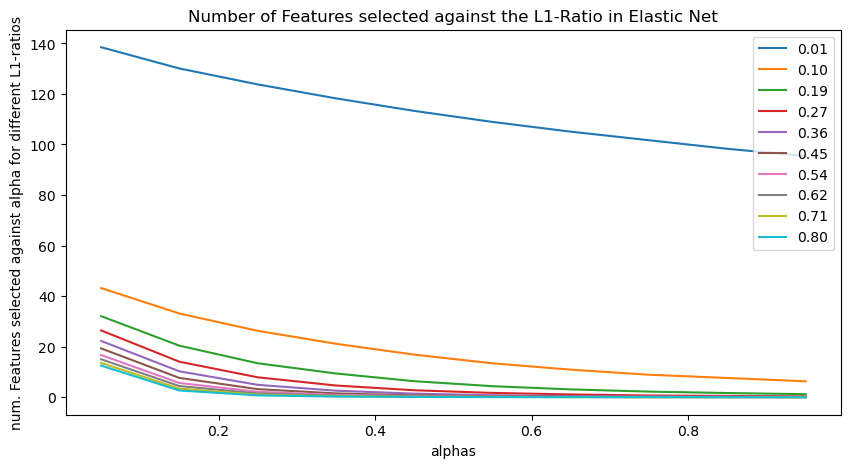

In [167]:
import matplotlib.pyplot as plt
plt.close()
plt.figure()
numFeatSelected_net[i, k, l]
for k in range(num_ratios):
    plt.plot(alphas,np.mean(numFeatSelected_net[:,k,:], axis=0), label=f"{ratios[k]:.02f}")
plt.xlabel('alphas')
plt.ylabel('num. Features selected against alpha for different L1-ratios')
plt.title('Number of Features selected against the L1-Ratio in Elastic Net')
plt.legend()
plt.show()

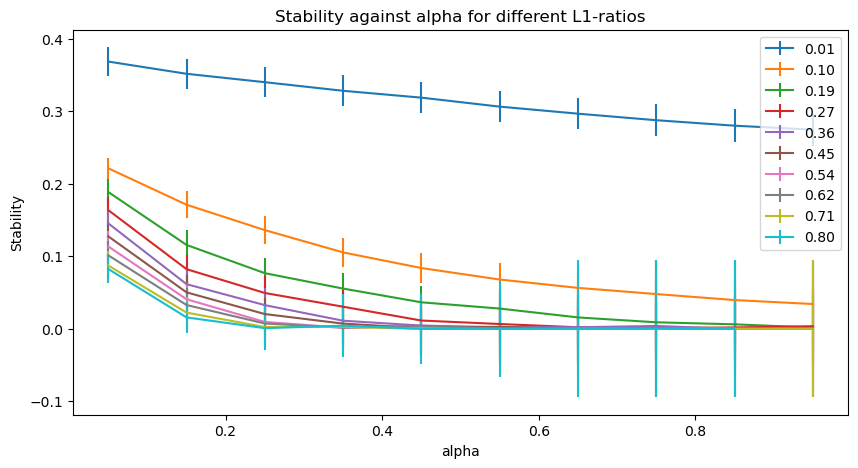

In [168]:
plt.close()
plt.figure()
for k in range(num_ratios):
    plt.errorbar(alphas, stabilities_net[k,:], yerr=errStab_net[k,:], label=f"{ratios[k]:.02f}")
plt.xlabel('alpha')
plt.ylabel('Stability')
plt.legend()
plt.title('Stability against alpha for different L1-ratios')
plt.show()

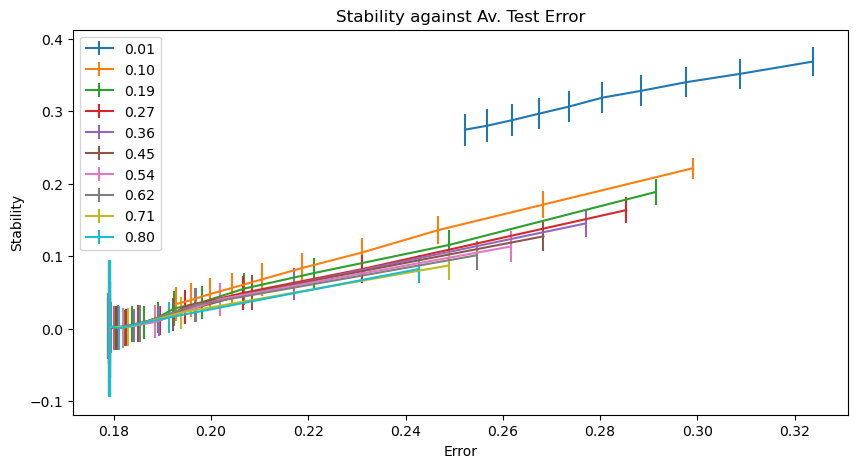

In [169]:
plt.close()
plt.figure()
for k in range(num_ratios):
    plt.errorbar(meanError_net[k,:], stabilities_net[k,:],yerr=errStab_net[k,:], label=f"{ratios[k]:.02f}")
plt.xlabel('Error')
plt.ylabel('Stability')
plt.title('Stability against Av. Test Error')
plt.legend()
plt.show()

# So we can use alpha = 0.2, ratio = 0.1 for ElasticNet

In [126]:
class FeatureSelector():
    def __init__(self, *args, **kwargs):
        self.m = kwargs["m"]
    
    def split_data_m_period(self, data_, m=30):
        data = data_.copy()
        months_periods = list(zip(np.arange(data.shape[0] % m, data.shape[0], m), np.arange(data.shape[0] % m + m, data.shape[0] + 1, m)))
        data_months_periods = []
        for start, end in months_periods:
            data_months_periods.append(data.iloc[start:end])
        return data_months_periods

# EmbededSelector

In [128]:
class EmbededSelector(FeatureSelector):
    """
    Here we use ElasticNet (l1)
    """
    def __init__(self, m=30, alpha=0.05, alpha_elast=0.2, ratio_elast=0.1):
        super().__init__(m=m)
        self.alpha = alpha
        self.alpha_elast = alpha_elast
        self.ratio_elast = ratio_elast
        self.model = ElasticNet(alpha=alpha_elast, l1_ratio=ratio_elast, max_iter=500) ## we use elastic net
        self.ss = StandardScaler()
        self.d = None
        self.M = None
        self.Z = None
        self.errors = None
        self.stabilities = None
        self.errStab = None
        self.numFeatSelected= None
        self.meanError = None
        self.data = None
        self.data_months_periods = None
        
    def select(self, data, target_col="Balance_resid", columns_to_drop = ["Balance"]):
        self.data = data.drop(columns=columns_to_drop)
        self.data_months_periods = self.split_data_m_period(self.data, m=self.m)
        
        self.d = self.data.shape[1] - 1 # number of features 
        self.M = (self.data.shape[0] // self.m) - 1 # number of bootstrap samples
        self.Z=np.zeros((self.M, self.d),dtype=np.int8)
        self.errors=np.zeros((self.M))
        self.stabilities=0
        self.errStab=0
        self.numFeatSelected=np.zeros((self.M),dtype=np.int32)
        self.ss.fit(self.data.drop(columns=[target_col])) #for stabilization. a bit leak
        for i in tqdm(range(self.M)):
            self.run_model(self.data_months_periods, i, target_col)
            
        self.meanError = np.mean(self.errors, 0)
        self.res = st.confidenceIntervals(self.Z, alpha=self.alpha)
        self.avg_num_feats = int(self.Z.sum(axis=1).mean())
        self.stabilities = self.res['stability']
        self.errStab = self.stabilities - self.res['lower']
        
    def run_model(self, data_months_periods_, i, target_col):
        data_months_periods = data_months_periods_.copy()
        X_train, y_train = data_months_periods[i].drop(columns=[target_col]), data_months_periods[i][[target_col]]
        X_test, y_test = data_months_periods[i + 1].drop(columns=[target_col]), data_months_periods[i + 1][[target_col]]
        X_train = self.ss.transform(X_train)
        X_test = self.ss.transform(X_test)
        self.model.fit(X_train, y_train)
        self.Z[i, self.model.coef_ != 0] = 1
        self.numFeatSelected[i] = np.sum(self.Z[i],axis=0)    
        y_pred = self.model.predict(X_test)    
        self.errors[i] = metrics.mean_absolute_error(y_test, y_pred)
        
    def show_results(self):
        print("Stability result: ", self.res)
        print("Num features selected:", self.avg_num_feats)
        _, num_votes, cols, df_stat = self.topk()
        print(df_stat)
            
    def topk(self, k=50):
        if k is None:
            k = self.avg_num_feats
        
        num_votes = self.Z.sum(axis=0)
        ind = np.argpartition(num_votes, -k)[-k:]
        ind = ind[np.argsort(-num_votes[ind])]
        cols = self.data.columns[ind]
        
        return ind, num_votes[ind], cols, pd.DataFrame([cols, list(num_votes[ind])], index=["Feature", "Num Votes"]).T

In [196]:
data = trainval_resid.iloc[:-len(pipe.y_val_boost_test)].copy() #y_val_boost_test need for hyperopt lgbm selection
ss = StandardScaler()
target_col = "Balance"
columns_to_drop = ["Balance_resid", "Balanced_SARIMAX"]

In [198]:
emb_extractor = EmbededSelector()

emb_extractor.select(data)

emb_extractor.show_results()

100%|██████████| 41/41 [00:00<00:00, 56.27it/s]

Stability result:  {'stability': 0.13850428504739376, 'lower': 0.1190381422440452, 'upper': 0.15797042785074233}
Num features selected: 28
                                              Feature Num Votes
0     Balance__fft_coefficient__attr_"real"__coeff_15        18
1     Balance__fft_coefficient__attr_"angle"__coeff_7        17
2    Balance__fft_coefficient__attr_"angle"__coeff_10        17
3    Balance__fft_coefficient__attr_"angle"__coeff_12        17
4                                             Tuesday        16
5                                              Monday        16
6     Balance__fft_coefficient__attr_"real"__coeff_11        15
7     Balance__fft_coefficient__attr_"real"__coeff_10        15
8     Balance__fft_coefficient__attr_"angle"__coeff_8        15
9    Balance__fft_coefficient__attr_"angle"__coeff_15        14
10   Balance__fft_coefficient__attr_"angle"__coeff_11        14
11     Balance__fft_coefficient__attr_"imag"__coeff_7        13
12   Balance__fft_coefficient

In [200]:
_, _, _, df = emb_extractor.topk()

In [202]:
df

,Feature,Num Votes
0,"Balance__fft_coefficient__attr_""real""__coeff_15",18
1,"Balance__fft_coefficient__attr_""angle""__coeff_7",17
2,"Balance__fft_coefficient__attr_""angle""__coeff_10",17
3,"Balance__fft_coefficient__attr_""angle""__coeff_12",17
4,Tuesday,16
5,Monday,16
6,"Balance__fft_coefficient__attr_""real""__coeff_11",15
7,"Balance__fft_coefficient__attr_""real""__coeff_10",15
8,"Balance__fft_coefficient__attr_""angle""__coeff_8",15
9,"Balance__fft_coefficient__attr_""angle""__coeff_15",14


# FilterSelector

In [205]:
class FilterSelector(FeatureSelector):
    """
    Here we use ElasticNet (l1)
    """
    def __init__(self, m=30, alpha=0.05, max_feats=50):
        super().__init__(m=m)
        self.max_feats = max_feats
        self.ss = StandardScaler()
        self.d = None
        self.M = None
        self.Z = None
        self.stabilities = None
        self.errStab = None
        self.data = None
        self.data_months_periods = None
        self.mutualInfos = None
        self.alpha = alpha
        
    def select(self, data, target_col="Balance_resid", columns_to_drop = ["Balance"]): #add to superclass
        self.data = data.drop(columns=columns_to_drop)
        self.data_months_periods = self.split_data_m_period(self.data, m=self.m)
        
        self.d = self.data.shape[1] - 1 # number of features 
        self.M = (self.data.shape[0] // self.m) - 1 # number of bootstrap samples
        self.Z = np.zeros((self.M, self.d), dtype=np.int8)
        self.stabilities = 0
        self.errStab = 0
        self.numFeatSelected = np.zeros((self.M),dtype=np.int32)
        self.ss.fit(self.data.drop(columns=[target_col])) #for stabilization. a bit leak
        for i in tqdm(range(self.M)):
            self.run_model(self.data_months_periods, i, target_col)
            
        self.res = st.confidenceIntervals(self.Z, alpha=self.alpha)
        self.avg_num_feats = int(self.Z.sum(axis=1).mean())
        self.stabilities = self.res['stability']
        self.errStab = self.stabilities - self.res['lower']
        
    def run_model(self, data_months_periods_, i, target_col): #add to superclass
        data_months_periods = data_months_periods_.copy()
        X_train, y_train = data_months_periods[i].drop(columns=[target_col]), data_months_periods[i][[target_col]]
        X_train = self.ss.transform(X_train)
        self.mutualInfos = utils.getMutualInfos(X_train, y_train.values.flatten())
        
        ind = np.argsort(self.mutualInfos)
        topK = ind[range(self.d-1, self.d-1-self.max_feats, -1)] 
        self.Z[i, topK] = 1 
        
    def show_results(self): #add to superclass
        print("Stability result: ", self.res)
        print("Num features selected:", self.avg_num_feats)
        _, num_votes, cols, df_stat = self.topk()
        print(df_stat)
            
    def topk(self, k=None):#add to superclass
        if k is None:
            k = self.max_feats
        
        num_votes = self.Z.sum(axis=0)
        ind = np.argpartition(num_votes, -k)[-k:]
        ind = ind[np.argsort(-num_votes[ind])]
        cols = self.data.columns[ind]
        
        return ind, num_votes[ind], cols, pd.DataFrame([cols, list(num_votes[ind])], index=["Feature", "Num Votes"]).T

In [240]:
fil_extractor = FilterSelector()

fil_extractor.select(data)

fil_extractor.show_results()

100%|██████████| 41/41 [00:09<00:00,  4.33it/s]

Stability result:  {'stability': 0.8702170605984411, 'lower': 0.8400052152067191, 'upper': 0.900428905990163}
Num features selected: 50
                                              Feature Num Votes
0              Balance__ar_coefficient__coeff_7__k_10        41
1              Balance__ar_coefficient__coeff_5__k_10        41
2              Balance__ar_coefficient__coeff_4__k_10        41
3              Balance__ar_coefficient__coeff_3__k_10        41
4              Balance__ar_coefficient__coeff_2__k_10        41
5              Balance__ar_coefficient__coeff_1__k_10        41
6              Balance__ar_coefficient__coeff_0__k_10        41
7      Balance__fft_coefficient__attr_"real"__coeff_1        41
8      Balance__fft_coefficient__attr_"real"__coeff_2        41
9      Balance__fft_coefficient__attr_"real"__coeff_3        41
10             Balance__ar_coefficient__coeff_6__k_10        41
11     Balance__fft_coefficient__attr_"real"__coeff_4        41
12     Balance__fft_coefficient_

In [ ]:
# rfecv на lasso

# WrappedSelector

In [258]:
class WrappedSelector(FeatureSelector):
    """
    Here we use 
    """
    def __init__(self, m=30, alpha=0.05, max_feats=20, alpha_elast=0.2, ratio_elast=0.1):
        super().__init__(m=m)
        self.alpha = alpha
        self.alpha_elast = alpha_elast
        self.ratio_elast = ratio_elast
        self.model = ElasticNet(alpha=alpha_elast, l1_ratio=ratio_elast, max_iter=500) ## we use elastic net
        time_split = TimeSeriesSplit(n_splits=3)
        self.selector = RFECV(estimator=self.model, step=1, cv=time_split, scoring='neg_mean_squared_error')
        self.ss = StandardScaler()
        self.d = None
        self.M = None
        self.Z = None
        self.max_feats = max_feats
        self.stabilities = None
        self.errStab = None
        self.numFeatSelected= None
        self.data = None
        self.data_months_periods = None
        
    def select(self, data, target_col="Balance_resid", columns_to_drop = ["Balance"], cols_pool = None):
        self.data = data.drop(columns=columns_to_drop)
        self.data = self.data[[target_col] + cols_pool]
        self.data_months_periods = self.split_data_m_period(self.data, m=self.m)
        
        self.d = self.data.shape[1] - 1 # number of features 
        self.M = (self.data.shape[0] // self.m) - 1 # number of bootstrap samples
        self.Z=np.zeros((self.M, self.d),dtype=np.int8)
        self.stabilities=0
        self.errStab=0
        self.numFeatSelected=np.zeros((self.M),dtype=np.int32)
        self.ss.fit(self.data.drop(columns=[target_col])) #for stabilization. a bit leak
        for i in tqdm(range(self.M)):
            self.run_model(self.data_months_periods, i, target_col)
            
        self.res = st.confidenceIntervals(self.Z, alpha=self.alpha)
        self.avg_num_feats = int(self.Z.sum(axis=1).mean())
        self.stabilities = self.res['stability']
        self.errStab = self.stabilities - self.res['lower']
        
    def run_model(self, data_months_periods_, i, target_col):
        data_months_periods = data_months_periods_.copy()
        X_train, y_train = data_months_periods[i].drop(columns=[target_col]), data_months_periods[i][[target_col]]
        X_train = self.ss.transform(X_train)
        #Cross Validation Definition
        
        
        self.selector.fit(X_train, y_train)
        
        self.Z[i, self.selector.support_] = 1
        self.numFeatSelected[i] = np.sum(self.Z[i],axis=0)    
        
        
    def show_results(self):
        print("Stability result: ", self.res)
        print("Num features selected:", self.avg_num_feats)
        _, num_votes, cols, df_stat = self.topk()
        print(df_stat)
            
    def topk(self, k=20):
        if k is None:
            k = self.max_feats
        
        num_votes = self.Z.sum(axis=0)
        ind = np.argpartition(num_votes, -k)[-k:]
        ind = ind[np.argsort(-num_votes[ind])]
        cols = self.data.columns[ind]
        
        return ind, num_votes[ind], cols, pd.DataFrame([cols, list(num_votes[ind])], index=["Feature", "Num Votes"]).T

In [260]:
wrap_extractor = WrappedSelector()

_, _, cols, _ = fil_extractor.topk(50)

wrap_extractor.select(data, cols_pool=list(cols))

wrap_extractor.show_results()

100%|██████████| 41/41 [00:02<00:00, 16.46it/s]


In [267]:
wrap_extractor.show_results()

Stability result:  {'stability': 0.012013030516195955, 'lower': -0.009515364742382189, 'upper': 0.0335414257747741}
Num features selected: 3
                                              Feature Num Votes
0      Balance__fft_coefficient__attr_"abs"__coeff_11         8
1      Balance__fft_coefficient__attr_"imag"__coeff_1         6
2   Balance__cwt_coefficients__coeff_13__w_10__wid...         6
3    Balance__fft_coefficient__attr_"angle"__coeff_15         5
4   Balance__cwt_coefficients__coeff_12__w_20__wid...         5
5   Balance__cwt_coefficients__coeff_13__w_20__wid...         5
6   Balance__cwt_coefficients__coeff_14__w_5__widt...         5
7      Balance__fft_coefficient__attr_"real"__coeff_8         5
8      Balance__fft_coefficient__attr_"real"__coeff_2         5
9   Balance__cwt_coefficients__coeff_13__w_5__widt...         4
10             Balance__ar_coefficient__coeff_5__k_10         4
11     Balance__fft_coefficient__attr_"real"__coeff_6         4
12             Balance__ar_

In [429]:
# выбираем пересечение всех топов
_, _, cols_wrap, _ = wrap_extractor.topk(5) #качество хуже, поэтому берем только самый топ
_, _, cols_fil, _ = fil_extractor.topk(30)
_, _, cols_emb, _ = emb_extractor.topk(30)

xgboost_features = list(set(cols_wrap)  | set(cols_fil) | set(cols_emb))

data_xgboost_train = trainval_resid.iloc[-len(pipe.y_val): -len(pipe.y_val_boost_test)].copy()
data_xgboost_val = trainval_resid.iloc[-len(pipe.y_val_boost_test):].copy()

target_col="Balance_resid"

data_xgboost_train, y_train_lgb = data_xgboost_train.loc[:, xgboost_features], data_xgboost_train.loc[:, target_col]
data_xgboost_val, y_val_lgb = data_xgboost_val.loc[:, xgboost_features], data_xgboost_val.loc[:, target_col]
ss = StandardScaler()
data_xgboost_train = ss.fit_transform(data_xgboost_train)
data_xgboost_val = ss.transform(data_xgboost_val)
train_data = lgb.Dataset(data_xgboost_train, label=y_train_lgb)
valid_data = lgb.Dataset(data_xgboost_val, label=y_val_lgb)

# Подбор гиперпараметров lgbm на resid от sarimax

In [432]:
def objective_lgbm(trial):
    param = { 
        'verbose': -1,
        'metric': 'mae',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    
    
    gbm = lgb.train(param, train_data, valid_sets=[valid_data])
    print(gbm.best_score.keys())
    return gbm.best_score['valid_0']['l1']


In [434]:
pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)

study_lgbm = optuna.create_study(direction="minimize", 
                                 pruner=pruner
                                )
study_lgbm.optimize(objective_lgbm, n_trials=100, show_progress_bar=True)

[I 2024-04-15 04:38:08,989] A new study created in memory with name: no-name-6d3253cb-8057-4c30-a52e-ea98d1fdf485


  0%|          | 0/100 [00:00<?, ?it/s]

dict_keys(['valid_0'])
[I 2024-04-15 04:38:09,383] Trial 0 finished with value: 0.14982873978114836 and parameters: {'n_estimators': 476, 'reg_alpha': 0.001047780041731516, 'reg_lambda': 0.04665929012815813, 'colsample_bytree': 0.38607466814206376, 'subsample': 0.7704206359483979, 'learning_rate': 1.265319831730119e-06, 'max_depth': 33, 'num_leaves': 756, 'min_data_per_groups': 87}. Best is trial 0 with value: 0.14982873978114836.
dict_keys(['valid_0'])
[I 2024-04-15 04:38:10,184] Trial 1 finished with value: 0.1498095373849133 and parameters: {'n_estimators': 690, 'reg_alpha': 1.2269179237376069, 'reg_lambda': 0.2503687601953407, 'colsample_bytree': 0.4728037256163227, 'subsample': 0.6983820699920292, 'learning_rate': 4.3086678103852135e-06, 'max_depth': 100, 'num_leaves': 263, 'min_data_per_groups': 6}. Best is trial 1 with value: 0.1498095373849133.
dict_keys(['valid_0'])
[I 2024-04-15 04:38:10,333] Trial 2 finished with value: 0.1492450435368384 and parameters: {'n_estimators': 227

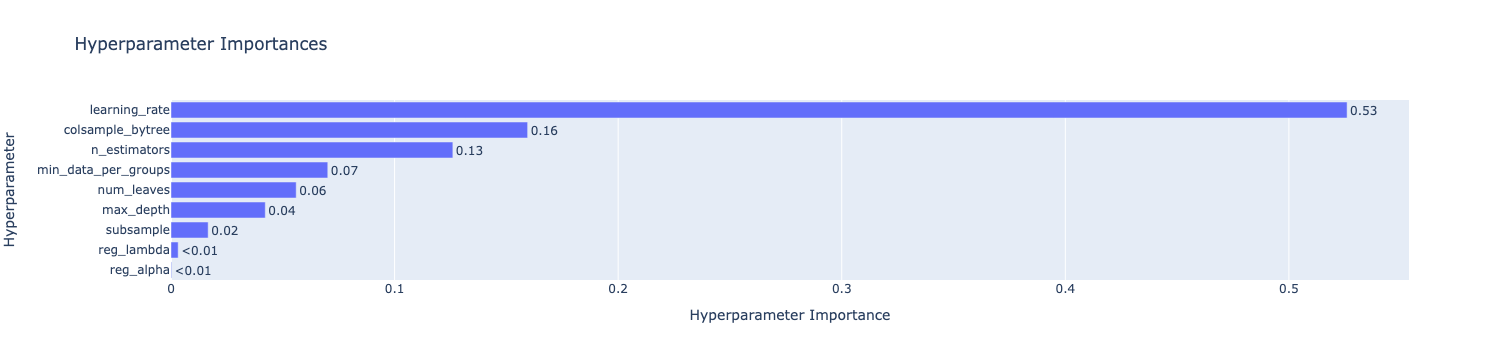

In [435]:
plot_param_importances(study_lgbm)

In [438]:
print(study_lgbm.best_params)

{'n_estimators': 323, 'reg_alpha': 0.0017202613307152784, 'reg_lambda': 0.4223512450430504, 'colsample_bytree': 0.7471231541484437, 'subsample': 0.6032849510724403, 'learning_rate': 0.0012239160719830207, 'max_depth': 55, 'num_leaves': 371, 'min_data_per_groups': 65}


In [551]:
gbm = lgb.train(study_lgbm.best_params, train_data, valid_sets=[valid_data])

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9903
[LightGBM] [Info] Number of data points in the train set: 519, number of used features: 61
[LightGBM] [Info] Start training from score -0.029994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [456]:
metrics.mean_absolute_error(gbm.predict(data_xgboost_val), y_val_lgb)

0.14675890670118052

In [460]:
pred_all, _ = pipe.sarimax_searcher.fit_predict_trainval(pipe.y_trainval, pipe.y_test)

Estimating SARIMAX


In [480]:
all_sarimax_prediction = pd.concat([pred_all, pipe.target], axis=1).dropna()
all_sarimax_prediction.columns = ["Balanced_SARIMAX", "Balance"]

In [482]:
all_sarimax_prediction

,Balanced_SARIMAX,Balance
2017-02-08,0.000000,0.196944
2017-02-09,0.017199,0.434681
2017-02-10,0.036738,0.183553
2017-02-11,0.012920,0.000000
2017-02-12,-0.001137,0.000000
...,...,...
2021-03-27,-0.212638,0.000000
2021-03-28,0.018095,0.000000
2021-03-29,-0.459354,-1.017679
2021-03-30,-0.262472,-0.259687


In [508]:
X_trainval = ss.fit_transform(pipe.X_trainval)
X_test = ss.transform(pipe.X_test)

In [521]:
Xs = pd.concat([pd.DataFrame(X_trainval), pd.DataFrame(X_test)], axis=0)
Xs.columns = pipe.X_trainval.columns
Xs.index=all_sarimax_prediction.index

In [523]:
all_resid = pd.concat([all_sarimax_prediction, Xs], axis=1)

all_resid["Balance_resid"] = all_resid["Balance"] - all_resid["Balanced_SARIMAX"] 

In [529]:
y, X = all_resid["Balance_resid"], all_resid[xgboost_features]

In [535]:
trainval_size = X_trainval.shape[0]

In [571]:
del study_lgbm.best_params["min_data_per_groups"]

In [581]:
study_lgbm.best_params

{'n_estimators': 323,
 'reg_alpha': 0.0017202613307152784,
 'reg_lambda': 0.4223512450430504,
 'colsample_bytree': 0.7471231541484437,
 'subsample': 0.6032849510724403,
 'learning_rate': 0.0012239160719830207,
 'max_depth': 55,
 'num_leaves': 371,
 'min_data_per_groups': 65}

In [589]:
test_resid = []
for i in tqdm(range(X_test.shape[0]+1)):
    pass

100%|██████████| 31/31 [00:00<00:00, 631181.67it/s]


In [603]:
test_resid = []
for i in tqdm(range(X_test.shape[0]+1)):

    subtrain_data = X.iloc[:trainval_size+i].values
    subtrain_y = y.iloc[:trainval_size+i].values

    subval_data = X.iloc[trainval_size+i:trainval_size+i+1].values
    subval_y = y.iloc[trainval_size+i:trainval_size+i+1].values

    subtrain_data = lgb.Dataset(subtrain_data, label=subtrain_y)
    subvalid_data = lgb.Dataset(subval_data, label=subval_y)

    gbm = lgb.train(study_lgbm.best_params, subtrain_data)
    test_resid.append(gbm.predict(subval_data)[0])

  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 62
[LightGBM] [Info] Start training from score -0.017663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

  3%|▎         | 1/31 [00:00<00:28,  1.06it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  6%|▋         | 2/31 [00:02<00:30,  1.05s/it]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 62
[LightGBM] [Info] Start training from score -0.017786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

 10%|▉         | 3/31 [00:03<00:29,  1.05s/it]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1486, number of used features: 62
[LightGBM] [Info] Start training from score -0.017657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

 13%|█▎        | 4/31 [00:04<00:27,  1.02s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 16%|█▌        | 5/31 [00:05<00:27,  1.04s/it]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 62
[LightGBM] [Info] Start training from score -0.017533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

 19%|█▉        | 6/31 [00:06<00:25,  1.02s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 23%|██▎       | 7/31 [00:07<00:26,  1.10s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 26%|██▌       | 8/31 [00:08<00:24,  1.08s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 29%|██▉       | 9/31 [00:09<00:23,  1.06s/it]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1492, number of used features: 62
[LightGBM] [Info] Start training from score -0.017730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

 32%|███▏      | 10/31 [00:10<00:21,  1.03s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 35%|███▌      | 11/31 [00:11<00:21,  1.07s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 62
[LightGBM] [Info] Start training from score -0.018144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

 39%|███▊      | 12/31 [00:12<00:20,  1.07s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 42%|████▏     | 13/31 [00:13<00:20,  1.15s/it]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1496, number of used features: 62
[LightGBM] [Info] Start training from score -0.018094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

 45%|████▌     | 14/31 [00:15<00:19,  1.17s/it]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1497, number of used features: 62
[LightGBM] [Info] Start training from score -0.018287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

 48%|████▊     | 15/31 [00:16<00:19,  1.23s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 52%|█████▏    | 16/31 [00:18<00:19,  1.31s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 55%|█████▍    | 17/31 [00:19<00:18,  1.33s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 58%|█████▊    | 18/31 [00:20<00:17,  1.33s/it]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1501, number of used features: 62
[LightGBM] [Info] Start training from score -0.018947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

 61%|██████▏   | 19/31 [00:22<00:16,  1.34s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 65%|██████▍   | 20/31 [00:23<00:15,  1.40s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1503, number of used features: 62
[LightGBM] [Info] Start training from score -0.018899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

 68%|██████▊   | 21/31 [00:25<00:13,  1.40s/it]

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1504, number of used features: 62
[LightGBM] [Info] Start training from score -0.019147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

 71%|███████   | 22/31 [00:26<00:12,  1.43s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wis

 74%|███████▍  | 23/31 [00:28<00:12,  1.52s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 77%|███████▋  | 24/31 [00:29<00:10,  1.49s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 81%|████████  | 25/31 [00:31<00:09,  1.51s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 62
[LightGBM] [Info] Start training from score -0.021030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

 84%|████████▍ | 26/31 [00:32<00:07,  1.43s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 87%|████████▋ | 27/31 [00:33<00:04,  1.25s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 90%|█████████ | 28/31 [00:34<00:03,  1.17s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14561
[LightGB

 94%|█████████▎| 29/31 [00:35<00:02,  1.09s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 97%|█████████▋| 30/31 [00:36<00:01,  1.02s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 97%|█████████▋| 30/31 [00:37<00:01,  1.24s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

IndexError: index 0 is out of bounds for axis 0 with size 0

In [621]:
TOTAL_TEST = pd.concat([all_resid.iloc[-X_test.shape[0]:].loc[:, ["Balanced_SARIMAX", "Balance", "Balance_resid"]], pd.DataFrame({"y_resid_lgbm_pred": test_resid}, index=all_resid.iloc[-X_test.shape[0]:].index)], axis=1)

In [625]:
TOTAL_TEST["Balance_pred"] = TOTAL_TEST["Balanced_SARIMAX"] + TOTAL_TEST["y_resid_lgbm_pred"]

In [631]:
metrics.mean_absolute_error(TOTAL_TEST["Balance"], TOTAL_TEST["Balanced_SARIMAX"])

0.32036386687304685

In [629]:
metrics.mean_absolute_error(TOTAL_TEST["Balance"], TOTAL_TEST["Balance_pred"])

0.3223239023482851

In [639]:
pipe.data_preproced.to_excel("../data/data_preproced.xlsx")